### Principal Component Analysis (PCA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.decomposition import (PCA, KernelPCA)  # dimensionality reduction

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV,
                                     learning_curve)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from scratch_libraries.utilities import plot_skew, plot_learning_curve, outlier_hunt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./datasets/glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)
print(df.head(5))

(214, 10)
        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1


In [3]:
# Check the distribution of the target variable ('Type')
print(df['Type'].value_counts())

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


---
#### Start of EDA Section

Before to introduce PCA let's do some Exploratory Data Analysis (EDA) on our dataset

---

**Skewness** measures the asymmetry of a distribution.
Specifically, it measures the deviation of the given distribution of a random variable from a symmetric distribution, such as normal distribution. A normal distribution is without any skewness, as it is symmetrical on both sides.

Hence, a curve is regarded as skewed if it is shifted towards the right or the left.

-> Ideally, the skewness value should be close to 0 for symmetrical distributions.

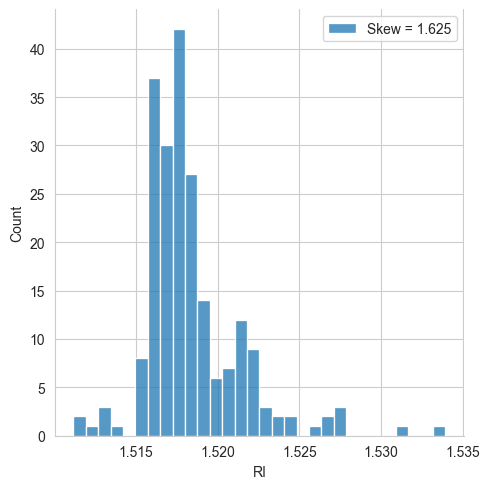

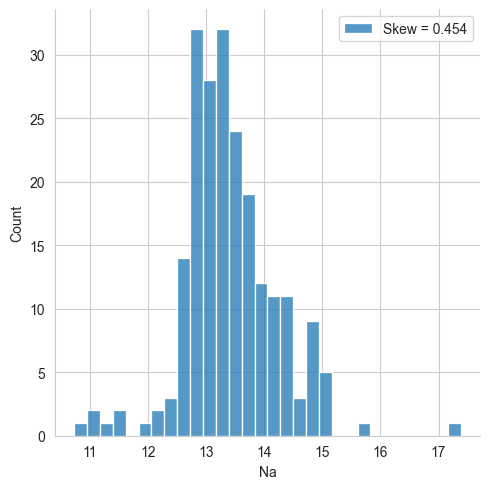

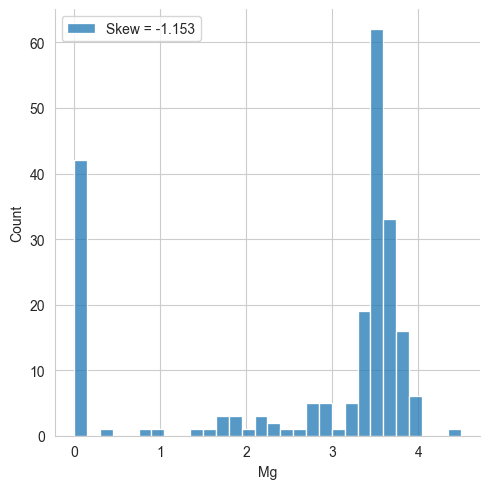

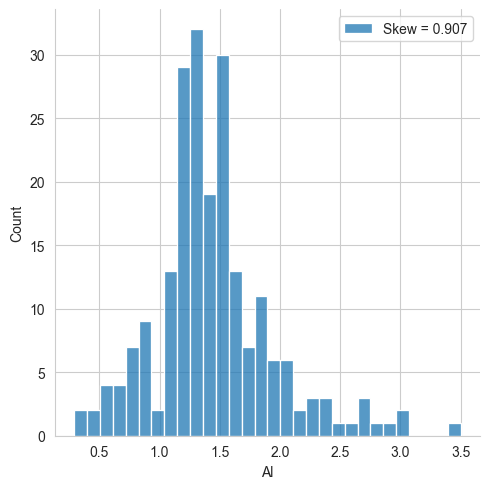

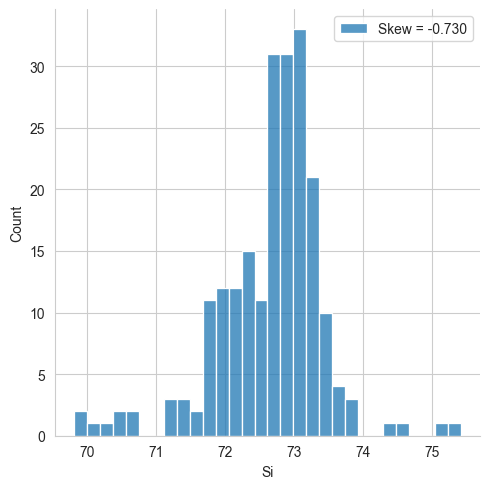

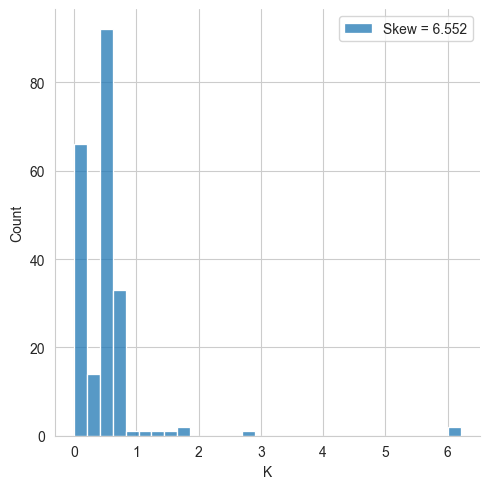

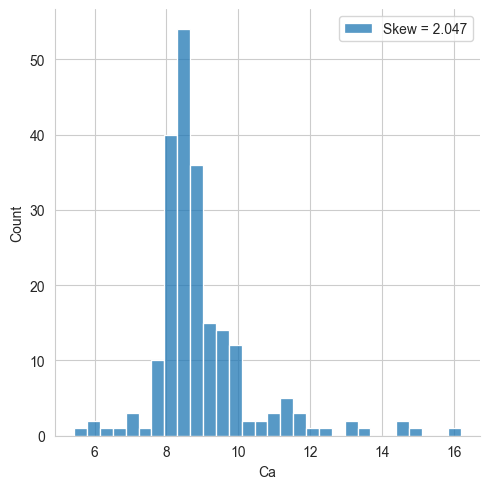

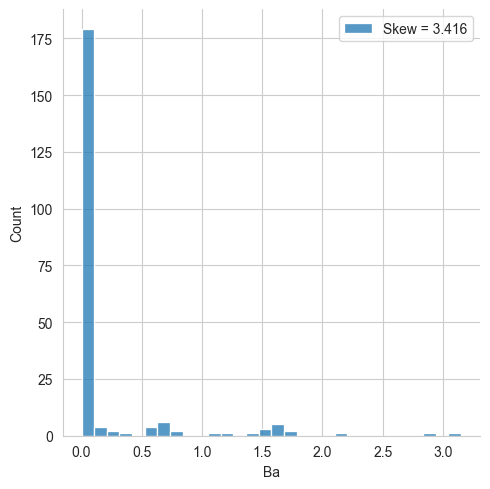

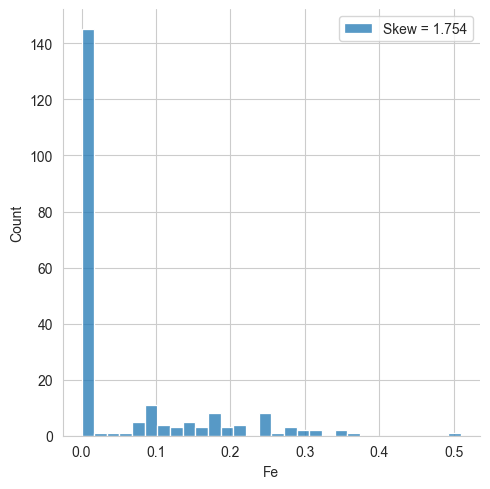

In [4]:
# Plot the skewness of each feature
plot_skew(df[features])

A positive skewness value indicates a distribution with a longer tail on the right side, while a negative skewness value indicates a distribution with a longer tail on the left side.

The magnitude of the skewness determines whether a distribution is moderately skewed, highly skewed, or extremely skewed.

Notably, the feature 'K' shows an extreme positive skewness, suggesting the presence of significant outliers.  Visual inspection of its distribution confirms the existence of prominent outliers.

So, let's get rid of the outliers.

In [5]:
# First let's detect and count the number of outliers in the dataset
print(f'Dataset has {len(outlier_hunt(df[features]))} elements as outliers')

Dataset has 14 elements as outliers


A **box plot** of the the distribution of features can help us in identifing potential outliers. It is a graphical representation of data distribution which shows:
- Box: The interquartile range ($ \text{IQR} $), where the lower and upper edges represent the 25th and 75th percentiles.
- Median: A (vertical) line inside the box marks the median (50th percentile).
- Whiskers: Extend to the smallest and largest values within $ 1.5 * \text{IQR} $ from the box.

All the points outside the whiskers are potential outliers.
For istance we can see that:
- Features like 'Na' and 'Al' have some points outside the whiskers, but these are pretty closer to the central range of the data. This indicates that probaly these are not outliers.
- Features like 'Ca' and 'Ba' have some points that are little more far from the whiskers. This indicates these are outliers, even if not so significant.
- Feature 'K' has a point significantly distant from the rest, indicating a significant outlier. This will impact highly on the skewness value.

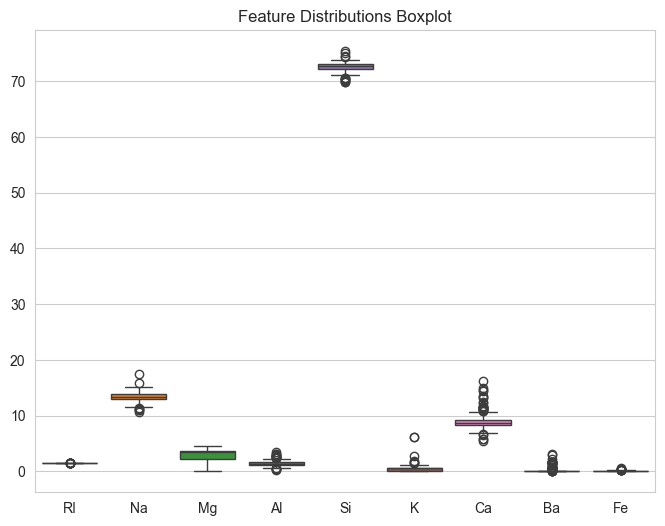

In [6]:
# Box plot of our features
plt.figure(figsize=(8,6))
sns.boxplot(df[features])
plt.title('Feature Distributions Boxplot')
plt.show()

In [7]:
# Remove outliers from the dataset
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(200, 10)


In [8]:
print(df['Type'].value_counts())

Type
1    70
2    70
7    25
3    17
5    10
6     8
Name: count, dtype: int64


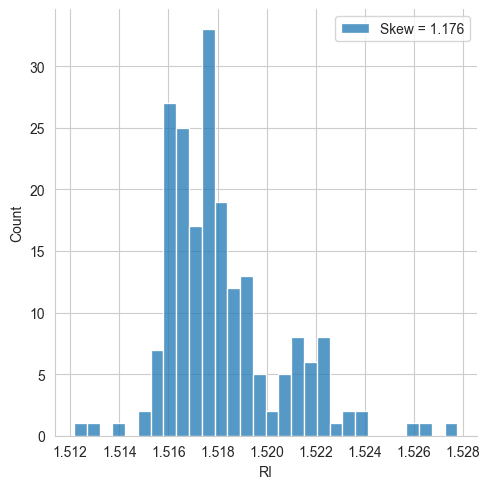

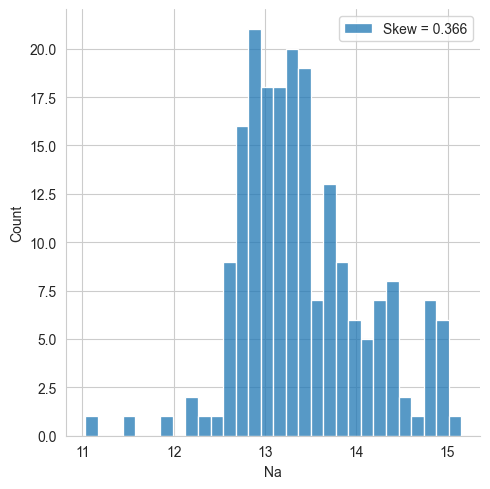

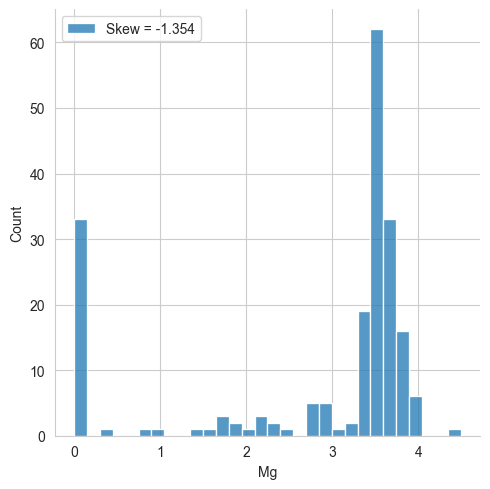

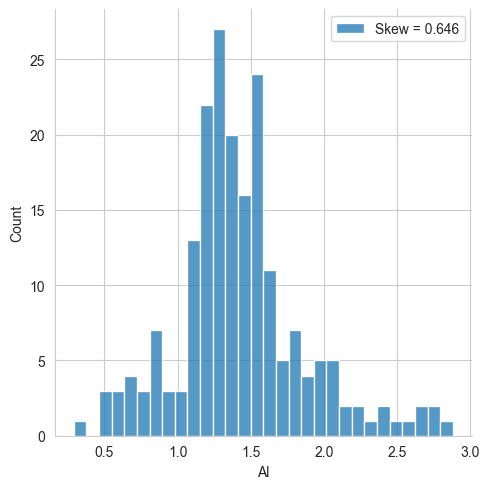

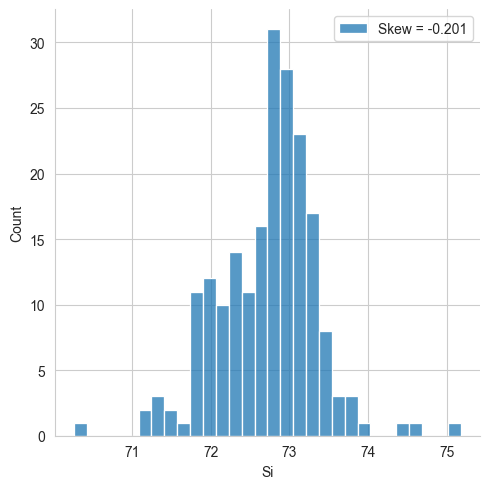

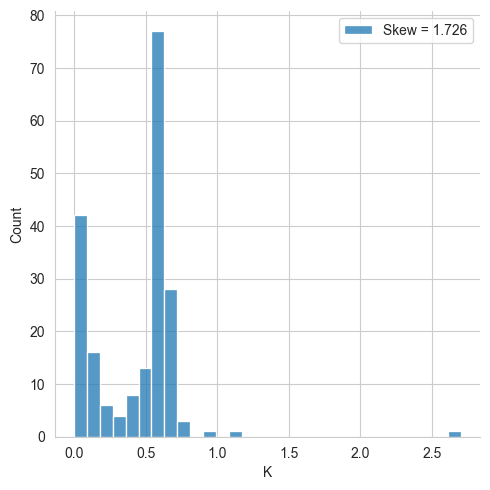

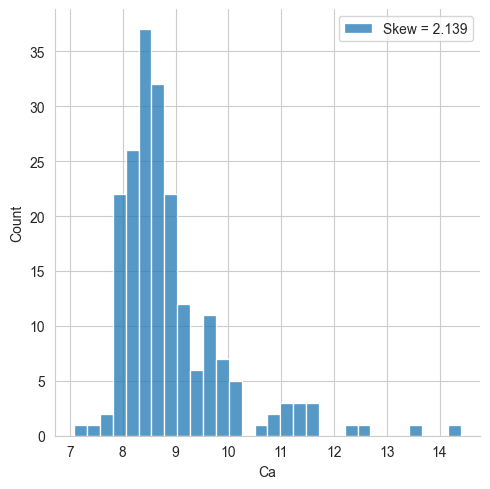

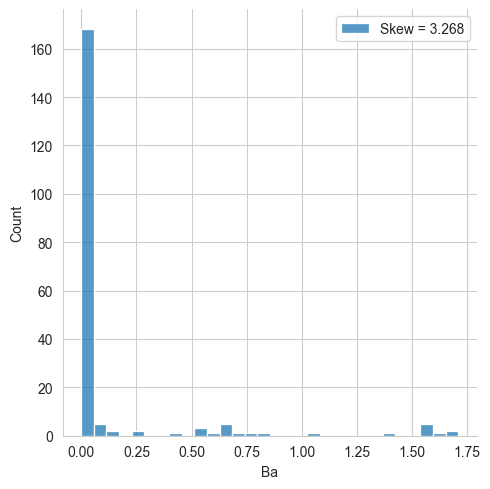

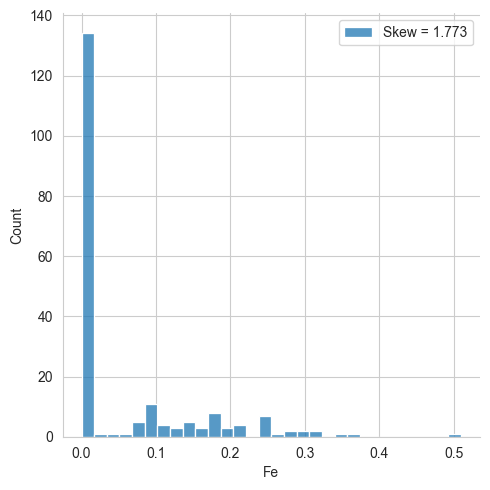

In [9]:
# Plot the skewness again after removing outliers
plot_skew(df[features])

We can see for example that 'K' skewness value has now a moderate value as consequence of have been removed an extreme outlier.


Before applying PCA, it’s helpful to visualize the correlation matrix to understand the relationships between features.

The correlation matrix highlights linear relationships between features. Strong linear relationships often indicate redundancy, as highly correlated features tend to carry overlapping information.

We know that PCA captures linear relationships between features. So, visualizing correlation matrix can give us gain an understanding of how PCA might combine strongly correlated features into fewer, compact uncorrelated features.

**Note**: A correlation matrix is scale-independent, so plotting it ensures that all features have been standardized. In fact a crucial step before appling PCA is the standardization of the features (step required just when the scale of the features is different, otherwise to apply PCA is just required to have a zero mean).

So, visualizing the correlation matrix, help pratically us to anticipate which components PCA will prioritize when reducing the dimensionality.

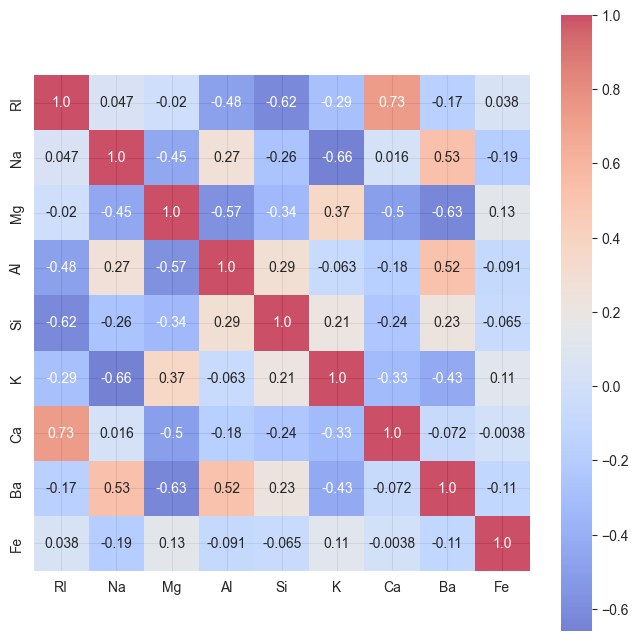

In [36]:
corr = df[features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, cbar=True, square=True, annot=True, fmt='.2',
            annot_kws={'size': 10}, xticklabels=features,
            yticklabels=features, alpha=0.7, cmap='coolwarm')
plt.show()

---

#### End of EDA Section

---

In [11]:
X = df[features]
y = df['Type']

test_size = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [12]:
# Let's standardize our data.
sc = StandardScaler()
X_train_normalized = sc.fit_transform(X_train)
X_test_normalized = sc.transform(X_test)

#### PCA

We first apply PCA to the dataset, keeping all the components (i.e., n components, where n is the number of features). 

By default, PCA uses Singular Value Decomposition (SVD) to decompose the data.

In [13]:
# Perform PCA
pca = PCA(n_components=X_train_normalized.shape[1], random_state=seed)  # Retain all n components
pca.fit(X_train_normalized)

PCA(n_components=9, random_state=42)

Now, we aim to determine the minimum number of components, $ k $, required to capture a variance above a specified threshold. In this case, we want to retain at least **80% of the total variance**.

To achieve this, we calculate the **cumulative explained variance ratio**, which allows us to track the proportion of variance explained as we include more components. It is computed as the cumulative sum of the explained variance ratio (i.e. explained variance of a given principal component over total variance ) of each principal component.

**Note**: The cumulative sum works directly with SVD because **the components are already ordered by decreasing importance**. However, if using Eigenvalue Decomposition (EVD), you must first reorder the components based on their eigenvalues.

In [14]:
var_exp = pca.explained_variance_ratio_  # Variance captured by each component
print(var_exp)

cum_var_exp = np.cumsum(var_exp)  # Cumulative sum of explained variance

[3.36906614e-01 2.72560006e-01 1.41511174e-01 1.06156574e-01
 6.15620225e-02 4.30083429e-02 2.80896685e-02 9.92097069e-03
 2.84627405e-04]


In [15]:
# Print cumulative variance explained 
for i, sum in enumerate(cum_var_exp):
    print("k=" + str(i+1), f"Cumulative variance explained: {cum_var_exp[i]*100} %")

k=1 Cumulative variance explained: 33.690661353490306 %
k=2 Cumulative variance explained: 60.94666194331793 %
k=3 Cumulative variance explained: 75.09777935460082 %
k=4 Cumulative variance explained: 85.71343680343864 %
k=5 Cumulative variance explained: 91.86963905447055 %
k=6 Cumulative variance explained: 96.1704733406551 %
k=7 Cumulative variance explained: 98.97944019042365 %
k=8 Cumulative variance explained: 99.97153725952992 %
k=9 Cumulative variance explained: 100.0 %


Let's also plot it.

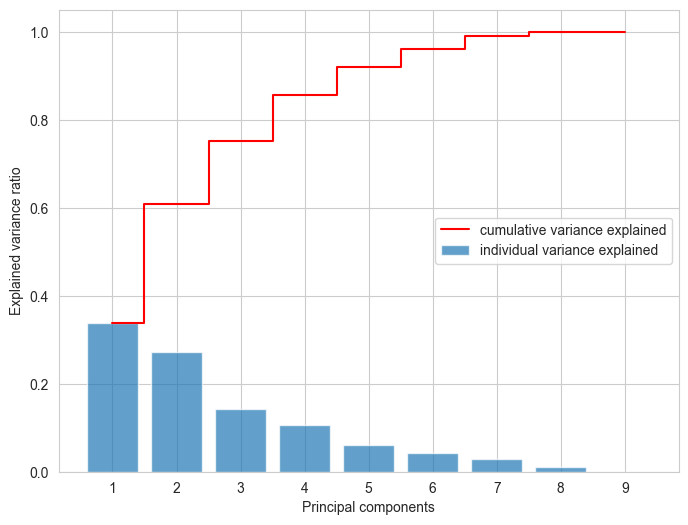

In [16]:
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

So, in our case to retain 80% of the variance we will need at least $ k=4 $ components.

Now, we can perform SVD and project our data in the lower k-dimensional space

In [17]:
pca = PCA(n_components=4, random_state=seed)
# The 'fit_transform' method first performs the SVD and then projects the original data into the lower k-dimensional space by 
# multipling the original data onto these components (U_reduced).
X_train_reduced = pca.fit_transform(X_train_normalized)
# Transform the test data into the same k-dimensional space using the components learned from the training set.
X_test_reduced = pca.transform(X_test_normalized)

print(X_train_reduced.shape) # Now we have k=4 features (reduced from the original n=9 features)
print(X_test_reduced.shape)

(160, 4)
(40, 4)


---

Now that we have reduced the dataset using PCA, let's demonstrate that the reduced features since retain most of the critical information, allow us to perform a classification task with COMPERABLE effectiveness as using the full set of features.

In [18]:
# First, we evaluate the classification results (accuracy) using the full dataset (with all 9 features). In this case we used a Kernel SVC
# (Support Vector Classification) as classification model and we use GridSearchCV to optimize the hyperparameters for classification.
# Of course the target variable is 'Type'.

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
params = {
    'C': [10, 50, 100],
    'kernel': ('linear', 'rbf', 'sigmoid'),
    'tol': [1e-2, 1e-3, 1e-4]
}
grid_full = GridSearchCV(estimator=SVC(random_state=seed), param_grid=params, cv=kfold,
             scoring='accuracy', verbose=1, n_jobs=-1)

grid_full.fit(X_train_normalized, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [10, 50, 100],
                         'kernel': ('linear', 'rbf', 'sigmoid'),
                         'tol': [0.01, 0.001, 0.0001]},
             scoring='accuracy', verbose=1)

In [19]:
print('--------BEST SCORE----------')
print(grid_full.best_score_*100)
print('--------BEST PARAM----------')
print(grid_full.best_params_)

--------BEST SCORE----------
72.5
--------BEST PARAM----------
{'C': 10, 'kernel': 'rbf', 'tol': 0.01}


In [20]:
# We now repeat the process, but this time using the reduced dataset with only 4 features (from PCA).
grid_reduced = GridSearchCV(estimator=SVC(random_state=seed), param_grid=params, cv=kfold,
             scoring='accuracy', verbose=1, n_jobs=-1)

grid_reduced.fit(X_train_reduced, y_train)

print('--------BEST SCORE----------')
print(grid_reduced.best_score_*100)
print('--------BEST PARAM----------')
print(grid_reduced.best_params_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
--------BEST SCORE----------
69.375
--------BEST PARAM----------
{'C': 100, 'kernel': 'rbf', 'tol': 0.01}


**Observations**: The accuracy dropped slightly from 72.5% (with all 9 features) to 69.375% (with 4 features). However, this shows that using PCA to reduce the dataset to 4 features still retains comparable performance, demonstrating that the reduced dataset effectively captures most of the relevant information.

Below we also report the **learning curves** for our best SVC using the reduced data

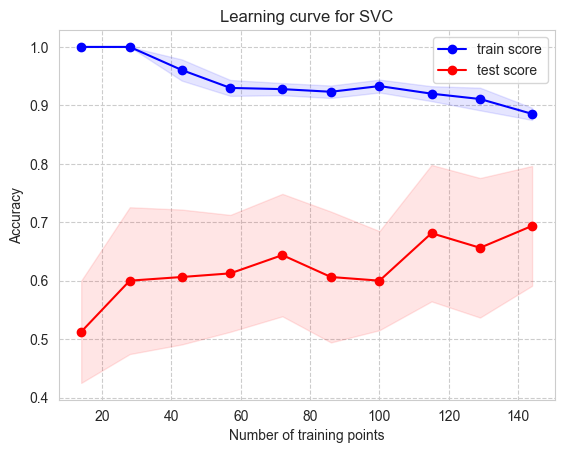

In [21]:
train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid_reduced.best_estimator_ , X= X_train_reduced, y = y_train,
                train_sizes=np.arange(0.1,1.1,0.1), cv=kfold,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for SVC')

---
#### Kernel PCA

Let's see what we get with **Kernel PCA** (instead of standard PCA)

In [22]:
kpca = KernelPCA(n_components=X.shape[1], kernel='rbf', random_state=seed)
kpca_transform = kpca.fit_transform(X_train_normalized)

In [23]:
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance) # explained variance over total variance = explained variance ratio
cum_var_exp = np.cumsum(explained_variance_ratio)

In [24]:
# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("k=" + str(i+1), f"Cumulative variance: {cum_var_exp[i]*100} %")

k=1 Cumulative variance: 34.11946682164363 %
k=2 Cumulative variance: 50.623126717099275 %
k=3 Cumulative variance: 66.34246160974007 %
k=4 Cumulative variance: 74.10626169944105 %
k=5 Cumulative variance: 80.85109825516135 %
k=6 Cumulative variance: 87.07745096189561 %
k=7 Cumulative variance: 92.44303481702605 %
k=8 Cumulative variance: 96.71172507525469 %
k=9 Cumulative variance: 100.0 %


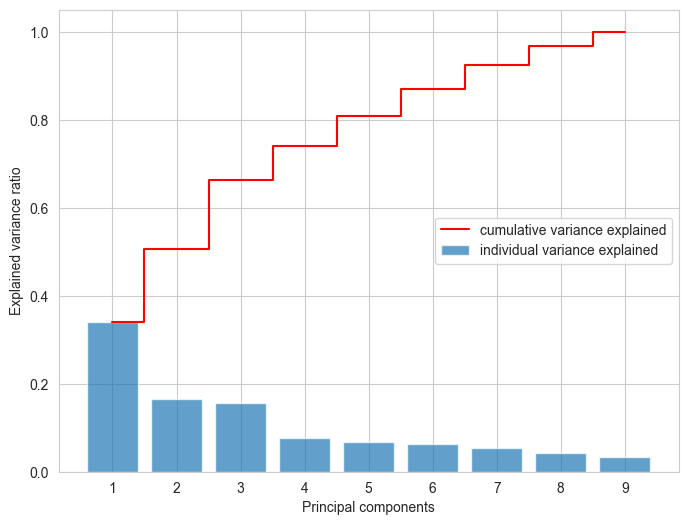

In [25]:
plt.figure(figsize=(8,6))
plt.bar(range(1,len(cum_var_exp)+1), explained_variance_ratio, align= 'center', label= 'individual variance explained', \
       alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', \
        color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(explained_variance_ratio)+1,1))
plt.legend(loc='center right')
plt.show()

In [26]:
kpca = KernelPCA(n_components=5, kernel='rbf', random_state=seed)
X_train_kernel_pca_reduced = kpca.fit_transform(X_train_normalized)
X_test_kernel_pca_reduced = kpca.transform(X_test_normalized)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
--------BEST SCORE----------
70.625
--------BEST PARAM----------
{'C': 10, 'kernel': 'rbf', 'tol': 0.01}


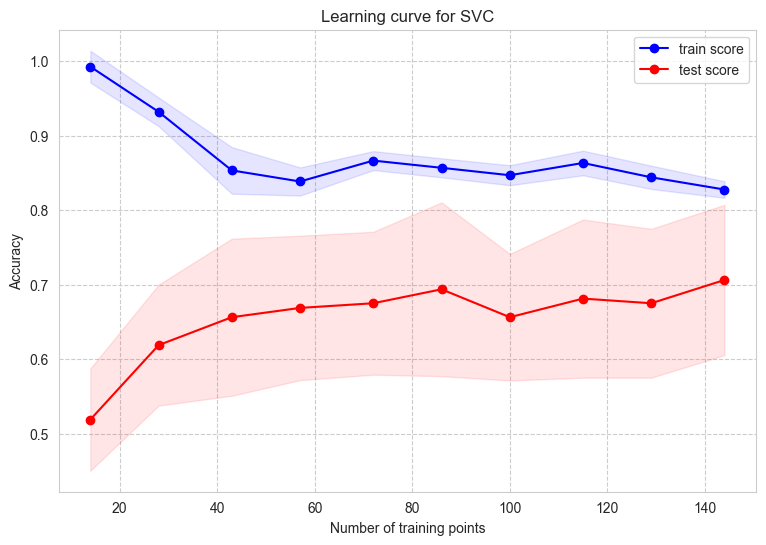

In [27]:
grid_kernel_pca = GridSearchCV(estimator=SVC(random_state=seed), param_grid=params, cv=kfold,
             scoring='accuracy', verbose=1, n_jobs=-1)

grid_kernel_pca .fit(X_train_kernel_pca_reduced, y_train)

print('--------BEST SCORE----------')
print(grid_kernel_pca .best_score_*100)
print('--------BEST PARAM----------')
print(grid_kernel_pca .best_params_)

plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid_kernel_pca .best_estimator_ , X= X_train_kernel_pca_reduced, y = y_train,
                train_sizes=np.arange(0.1,1.1,0.1), cv=kfold,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for SVC')

---

#### PCA with Pipeline

Pay attention to the order! It is important to perform normalization first and then feature selection based on the components identified with PCA.

In this case we use SciKit-Learn's Pipeline to perform these operations sequentially.

Fitting 10 folds for each of 27 candidates, totalling 270 fits
--------BEST SCORE----------
70.0
--------BEST PARAM----------
{'SVC__C': 10, 'SVC__kernel': 'rbf', 'SVC__tol': 0.01}


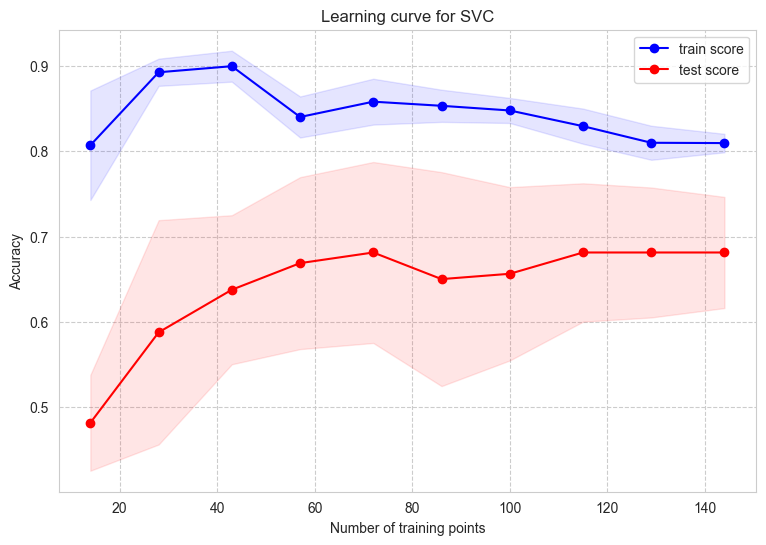

In [28]:
pipeline = Pipeline([
                      ('sc', StandardScaler()),
                      ('pca', PCA(n_components=4, random_state=seed)),
                      ('SVC', SVC(random_state=seed))])

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
params = [{
    'SVC__C': [10, 50, 100],
    'SVC__kernel': ('linear', 'rbf', 'sigmoid'),
    'SVC__tol': [1e-2, 1e-3, 1e-4]
}]
grid = GridSearchCV(pipeline, param_grid=params, cv=kfold,
             scoring='accuracy', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

print('--------BEST SCORE----------')
print(grid.best_score_*100)
print('--------BEST PARAM----------')
print(grid.best_params_)

plt.figure(figsize=(9,6))

train_sizes, train_scores, test_scores = learning_curve(
              estimator= grid.best_estimator_ , X= X_train, y = y_train,
                train_sizes=np.arange(0.1,1.1,0.1), cv= 10,  scoring='accuracy', n_jobs= - 1)

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for SVC')